In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.neighbors import KDTree
from train import Test
import cv2
from copy import deepcopy

In [5]:
class Visualizer:
    def __init__(self, datapath=None):
        self.datapath = datapath
        self.ids = [self.get_id(f) for f in os.listdir(self.datapath) if "rgb_" in f]
        
    def get_id(self, fname):
        return fname.split('_')[1].replace(".png", "")    

    def outer_inner_corresp(self, i=None):
        depth = np.load(os.path.join(self.datapath, "%s_depth.npy" % i))
#         variance = np.load(os.path.join(self.datapath, "%s_variance.npy" % i))
        green = Image.open(os.path.join(self.datapath, "%s_labels_green.png" % i))
        yellow = Image.open(os.path.join(self.datapath, "%s_labels_yellow.png" % i))
        red = Image.open(os.path.join(self.datapath, "%s_labels_red.png" % i))
        seg = np.stack([red, yellow, green], axis=-1)
        im_height, im_width, _ = seg.shape
        
        # Set regions of overlapping masks to 0
        seg[np.logical_and(seg[:,:,1]==255, seg[:,:,2]==255),2] = 0
        seg[np.logical_and(seg[:,:,1]==255, seg[:,:,2]==255),1] = 0
        
        # Get outer-inner edge correspondence
        xx, yy =  np.meshgrid([x for x in range(im_width)],
                              [y for y in range(im_height)])
        xx_o = xx[seg[:,:,1]==255]
        yy_o = yy[seg[:,:,1]==255]

        inner_edges_mask = np.ones((im_height, im_width))
        inner_edges_mask[seg[:,:,2]==255] = 0
        dists, lbl = cv2.distanceTransformWithLabels(inner_edges_mask.astype(np.uint8), cv2.DIST_L2, 
                                                     5, labelType=cv2.DIST_LABEL_PIXEL)

        # lbl provides at each pixel the index label of the closest zero point. 
        # Now we find the pixel coordinate of that index label
        inner_pxs = np.where(inner_edges_mask==0)
        xx_inner = inner_pxs[1] # x coords of inner edges
        yy_inner = inner_pxs[0] # y coords of inner edges
        labels_to_pxs = [[0, 0]] # fix off by one offset
        for j in range(len(yy_inner)):
            labels_to_pxs.append([yy_inner[j],xx_inner[j]])
        labels_to_pxs = np.array(labels_to_pxs)
        closest_inner_px = labels_to_pxs[lbl]
        
        # Visualize a fraction of the correspondences as arrows
#         factor = 20
#         plt.figure(dpi=150)
#         plt.imshow(seg)
#         plt.quiver(xx_o[::factor], yy_o[::factor], 
#                    closest_inner_px[yy_o[::factor], xx_o[::factor]][:,1]-xx_o[::factor], 
#                    -closest_inner_px[yy_o[::factor], xx_o[::factor]][:,0]+yy_o[::factor], 
#                    color='orange', scale_units='xy', scale=1.0)
        
        # Calculate distance to the closest inner edge point for every pixel in the image
        dist_to_inner = np.zeros(closest_inner_px.shape)
        dist_to_inner[:,:,0] = np.abs(closest_inner_px[:,:,0]-yy)
        dist_to_inner[:,:,1] = np.abs(closest_inner_px[:,:,1]-xx)
        
        # Normalize distance vectors
        mag = np.linalg.norm([dist_to_inner[:,:,0],dist_to_inner[:,:,1]],axis = 0)+0.00001
        dist_to_inner[:,:,0] = dist_to_inner[:,:,0]/mag
        dist_to_inner[:,:,1] = dist_to_inner[:,:,1]/mag

        # For every outer edge point, find its closest K neighbours 
        num_neighbour = 100
        outer_idxs = np.vstack([xx_o,yy_o])
        try:
            tree = KDTree(outer_idxs.T, leaf_size=2)
        except Exception as e:
            return 0, 0, 0, 0, 0, None, None, None
        if num_neighbour > xx_o.shape[0]:
            return 0, 0, 0, 0, 0, None, None, None
        dist, ind = tree.query(outer_idxs.T, k=num_neighbour)
        
        dist_to_inner_o = dist_to_inner[seg[:,:,1]==255,:]
        xx_neighbours = dist_to_inner_o[ind][:,:,1]
        yy_neighbours = dist_to_inner_o[ind][:,:,0]
        xx_var = np.var(xx_neighbours,axis = 1)
        yy_var = np.var(yy_neighbours,axis = 1)
        var = xx_var+yy_var
        var = var / var.max()
#         var = (var - var.min()) / (var.max() - var.min())
        var_map = np.zeros((im_height, im_width))
        for i in range(xx_o.shape[0]): # xx_o is flat
            var_map[yy_o[i]][xx_o[i]] = var[i]
        
        invvar = 1.0 - var # get inverse
#         pvar = invvar / np.sum(invvar)
        pvar = invvar
        pvar_map = np.zeros((im_height, im_width))
        for i in range(xx_o.shape[0]): # xx_o is flat
            pvar_map[yy_o[i]][xx_o[i]] = pvar[i]
        
        plt.figure()
        plt.subplots_adjust(top=1.5, right=1.5)
        plt.subplot(121)
        plt.imshow(var_map, vmin=var_map.min(), vmax=var_map.max())
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.title("New var: %0.5f %0.5f" % (var_map.min(), var_map.max()))
        
        plt.subplot(122)
#         plt.imshow(pvar_map, vmin=0.0, vmax=1.0)
        plt.imshow(pvar_map, vmin=pvar_map.min(), vmax=pvar_map.max())
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.title("New inv var: %0.5f %0.5f" % (pvar_map.min(), pvar_map.max()))
        plt.show()
        
#         np.save("/home/jianingq/Downloads/newvar.npy", pvar_map)

    def prob_map(self, i=None, model=None):
        # Get indices of test data
        if i == None:
            filename =  os.listdir(self.datapath)
            fnames = [f for f in filename if f.startswith("rgb")]
            test_data_num = int(len(fnames)/6)
#             print(test_data_num)
            i = np.random.choice(test_data_num) + test_data_num*5
            print(i)
        
        rgb = Image.open(os.path.join(self.datapath, "rgb_%s.png" % i))
        depth = np.load(os.path.join(self.datapath, "%s_depth.npy" % i))
        green = Image.open(os.path.join(self.datapath, "%s_labels_green.png" % i))
        yellow = Image.open(os.path.join(self.datapath, "%s_labels_yellow.png" % i))
        red = Image.open(os.path.join(self.datapath, "%s_labels_red.png" % i))
        
        max_d = np.nanmax(depth)
        depth[np.isnan(depth)] = max_d
        
        impred = np.stack([red, yellow, green], axis=-1)

        # Load raw variance and inverse variance maps
#         var = np.load(os.path.join(self.datapath, "%s_variance.npy" % i))
#         invvar = np.load(os.path.join(self.datapath, "%s_invvariance.npy" % i))
        yellow_npy = np.asarray(yellow)
        mask = np.zeros_like(yellow_npy, dtype=np.float32)
        mask[yellow_npy > 254] = 1.0
        newvar = np.load(os.path.join(self.datapath, "%s_newvar.npy" % i))
        newvar = (1 - newvar)*mask
#         invvar = invvar / invvar.max()
        
#         plt.figure()
#         plt.subplots_adjust(top=1.5, right=1.5)
#         plt.subplot(121)
#         plt.imshow(var)
#         plt.title("Current variance: %0.5f %0.5f" % (var.min(), var.max()))
#         plt.colorbar(fraction=0.046, pad=0.04)
        
# #         plt.scatter(pxs, pys, color=rewards, alpha=0.6)
#         plt.subplot(122)
#         plt.imshow(invvar, vmin=0, vmax=invvar.max())
#         plt.title("Current inverse variance: %0.5f %0.5f" % (invvar.min(), invvar.max()))
#         plt.colorbar(fraction=0.046, pad=0.04)
#         plt.show()
        
        if model == None: return
        out = model.evaluate(depth).squeeze()
        seg_pred = out[:, :, :3]
        prob_pred = out[:, :, -1] # mask out everything except outer edges
        
#         print(seg_pred.shape)
#         print(prob_pred.shape)
#         print(seg_pred[0, :5, 0])
#         print((np.uint8(seg_pred*255))[0, :5, 0])
#         seg_pred = Image.fromarray(np.uint8(seg_pred*255))
        
        yellow = np.asarray(yellow)
        mask = np.zeros_like(yellow)
        mask[yellow>254] = 1
#         prob_pred *= mask
        
        seg_pred_th = deepcopy(seg_pred)
        seg_pred_th[seg_pred_th < 0.8] = 0.0
        
#         plt.figure(dpi=150)
#         plt.subplot(141)
#         plt.imshow(rgb)
#         plt.subplot(142)
#         plt.imshow(seg_pred_th[:, :, 0], cmap="gray")
#         plt.subplot(143)
#         plt.imshow(seg_pred_th[:, :, 1], cmap="gray")
#         plt.subplot(144)
#         plt.imshow(seg_pred_th[:, :, 2], cmap="gray")
#         plt.show()
        
        # Compute metrics
        # MAP for segmentation
#         red = np.asarray(red)
#         corner = np.zeros_like(red, dtype=np.uint8)
#         corner[red > 254] = 1
#         yellow = np.asarray(yellow)
#         outer = np.zeros_like(yellow, dtype=np.uint8)
#         outer[yellow > 254] = 1
#         green = np.asarray(green)
#         inner = np.zeros_like(green, dtype=np.uint8)
#         inner[green > 254] = 1
#         g = np.stack([corner, outer, inner], axis=-1)
#         meanap = compute_map(g, seg_pred_th, 3)
#         print("Mean AP Corners %0.3f, Outer Edges %0.3f, Inner Edges %0.3f" % (meanap[0], meanap[1], meanap[2]))
        
        # Display 
#         plt.figure(dpi=300)
# #         plt.subplots_adjust(left=0.5)
#         plt.subplot(231)
#         plt.title("rgb")
#         plt.imshow(rgb)
#         plt.axis("off")
#         plt.subplot(232)
#         plt.title("gt seg")
#         plt.imshow(impred)
#         plt.axis("off")
#         plt.subplot(233)
#         plt.title("gt var")
#         plt.imshow(newvar, vmin=0, vmax=1)
#         plt.colorbar(fraction=0.046, pad=0.04)
#         plt.axis("off")
#         plt.subplot(235)
#         plt.title("model seg")
#         plt.imshow(seg_pred_th)
#         plt.axis("off")
#         plt.subplot(236)
#         plt.title("model var")
#         plt.imshow(prob_pred, vmin=0, vmax=1)
#         plt.colorbar(fraction=0.046, pad=0.04)
# #         plt.tight_layout()
#         plt.axis("off")
#         plt.show() 
        
        plt.figure(dpi=300)
#         plt.subplots_adjust(left=0.5)
        plt.subplot(141)
        plt.title("rgb")
        plt.imshow(rgb)
        plt.axis("off")
        plt.subplot(142)
        plt.title("gt seg")
        plt.imshow(impred)
        plt.axis("off")
        plt.subplot(143)
        plt.title("model raw")
        plt.axis("off")
        plt.imshow(seg_pred)
        plt.subplot(144)
        plt.title("model thresh")
        plt.imshow(seg_pred_th)
#         plt.tight_layout()
        plt.axis("off")
        plt.show()

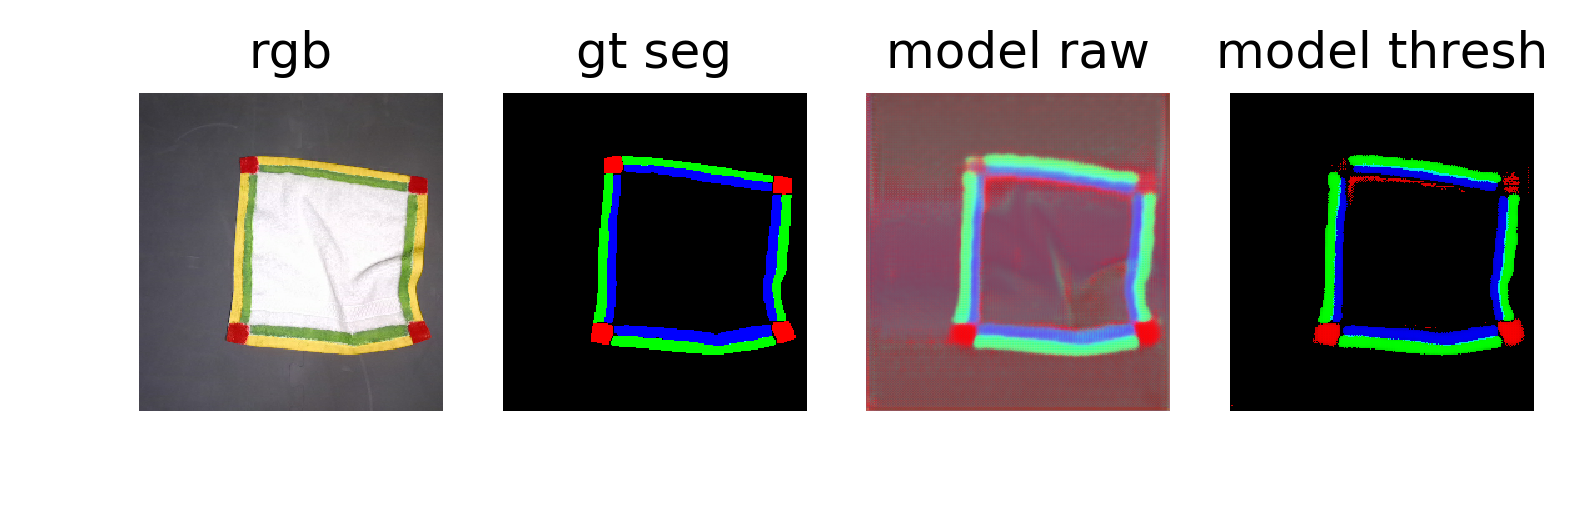

In [6]:
model_id = 271
epoch = 160
pretrained_model = "/media/ExtraDrive2/jianingq/train_runs/dbg/%d/chkpnts/dbg%d_epoch%d" % (model_id, model_id, epoch)
# pretrained_model = "/media/ExtraDrive2/jianingq/models_towel/dbg2_epoch_240"
datapath = "/home/jianingq/data_8singleim/camera_3"
t = Test(model_path=pretrained_model, n_features=6)
v = Visualizer(datapath)
# v.prob_map(model=t)
# v.prob_map(i=4556, model=t)
v.prob_map(i=0, model=t)
# v.outer_inner_corresp(0)